In [10]:
import numpy as np
from scipy.signal import stft, istft, hann, check_COLA
from scipy.io import wavfile
import matplotlib.pyplot as plt
from os.path import basename, splitext, split
from scipy.io import wavfile
from os import listdir, walk
import errno
import time
import glob

### Pre-processing steps need to do the following:
1. Convert data to mono. Currently we average the channels
2. Generate spectrograms. Try STFT and wavelets

In [2]:
"""
    This file is part of DeepConvSep.
    Copyright (c) 2014-2017 Marius Miron  <miron.marius at gmail.com>
    DeepConvSep is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.
    DeepConvSep is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    You should have received a copy of the Affero GPL License
    along with DeepConvSep.  If not, see <http://www.gnu.org/licenses/>.
 """

import scipy
import numpy as np
from scipy import io
from collections import defaultdict
import os
import sys
from os import listdir
from os.path import isfile, join
import itertools
import math
import random
import re
#import util
#from util import *

def sinebell(lengthWindow):
    """
    window = sinebell(lengthWindow)
    Computes a \"sinebell\" window function of length L=lengthWindow
    The formula is:
    .. math::
        window(t) = sin(\pi \\frac{t}{L}), t=0..L-1
    """
    window = np.sin((np.pi*(np.arange(lengthWindow)))/(1.0*lengthWindow))
    return window


class Transforms(object):
    """
    A general class which can be extended to compute features from audio (STFT,CQT)
    Parameters
    ----------
    frameSize : int, optional
        The frame size for the analysis in samples
    hopSize : int, optional
        The hop size for the analysis in samples
    sampleRate : int, optional
        The sample rate at which to read the signals
    window : function, optional
        The window function for the analysis
    """
    def __init__(self, ttype='fft', bins=48, frameSize=1024, hopSize=256, tffmin=25, tffmax=18000, iscale = 'lin', suffix='', sampleRate=44100, window=np.hanning):
        self.bins = bins
        self.frameSize = frameSize
        self.hopSize = hopSize
        self.fmin = tffmin
        self.fmax = tffmax
        self.iscale = iscale
        self.suffix=suffix
        self.sampleRate = sampleRate
        self.ttype = ttype
        self.window = window(self.frameSize)

    def compute_transform(self,audio, out_path=None, phase=False, save=True):
        """
        Compute the features for a given set of audio signals.
            The audio signal \"audio\" is a numpy array with the shape (t,i) - t is time and i is the id of signal
            Depending on the variable \"save\", it can save the features to a binary file, accompanied by a shape file,
            which is useful for loading the binary data afterwards
        Parameters
        ----------
        audio : 2D numpy array
            The array comprising the audio signals
        out_path : string, optional
            The path of the directory where to save the audio.
        save : bool, optional
            To return or to save in the out_path the computed features
        phase : bool, optional
            To return/save the phase
        Yields
        ------
        mag : 3D numpy array
            The features computed for each of the signals in the audio array, e.g. magnitude spectrograms
        phs: 3D numpy array
            The features computed for each of the signals in the audio array, e.g. phase spectrograms
        """
        self.out_path = out_path
        for i in range(audio.shape[1]):
            if phase:
                mag,ph=self.compute_file(audio[:,i], phase=True, sampleRate=self.sampleRate)
            else:
                mag=self.compute_file(audio[:,i], phase=False, sampleRate=self.sampleRate)
            if i==0:
                mags = np.zeros((audio.shape[1],mag.shape[0],mag.shape[1])) #This line will be used when using without phase
                if phase:
                    if len(ph.shape)==3:
                        phs = np.zeros((audio.shape[1],ph.shape[0],ph.shape[1],ph.shape[2]))
                    else:
                        phs = np.zeros((audio.shape[1],ph.shape[0],ph.shape[1]))
            mags[i]=mag
            if phase:
                phs[i]=ph

        if save and self.out_path is not None:
            self.saveTensor(mags,'_'+self.suffix+'_m_')
            if phase:
                self.saveTensor(phs,'_'+self.suffix+'_p_')
            mags = None
            phase = None
        else:
            if phase:
                return mags,phs
            else:
                return mags

    def compute_playing(self,audio, out_path):
        """
        Function to compute playing/not playing labels for the audio files
        Parameters
        ----------
        audio : 2D numpy array
            The array comprising the audio signals
        out_path : string, optional
            The path of the directory where to save the audio.
        """
        self.out_path = out_path
        ndim=audio.shape[1]/self.sampleRate*self.hopSize
        labels=np.zeros((ndim,audio.shape[1]))
        for i in range(audio.shape[1]):
            for j in range(ndim-1):
                if abs(audio[self.hopSize*i:self.hopSize*(i+1)]).mean()>0.02:
                    labels[j,i]=1
        self.saveTensor(labels,'_'+self.suffix+'_l_')

    def compute_file(self,audio, phase=False):
        return None

    def compute_inverse(self, mag, phase):
        return None

    def saveTensor(self, t, name='_cqt_m_'):
        """
        Saves a numpy array as a binary file
        """
        print(name)
        t.tofile(self.out_path.replace('.data',name+'.data'))
        #save shapes
        self.shape = t.shape
        self.save_shape(self.out_path.replace('.data',name+'.shape'),t.shape)

    def loadTensor(self, name='_cqt_m_'):
        """
        Loads a binary .data file
        """
        f_in = np.fromfile(self.out_path.replace('.data',name+'.data'))
        shape = self.get_shape(self.out_path.replace('.data','.shape'))
        if self.shape == shape:
            f_in = f_in.reshape(shape)
            return f_in
        else:
            print('Shape of loaded array does not match with the original shape of the transform')

    def save_shape(self,shape_file,shape):
        """
        Saves the shape of a numpy array
        """
        with open(shape_file, 'w') as fout:
            fout.write(u'#'+'\t'.join(str(e) for e in shape)+'\n')

    def get_shape(self,shape_file):
        """
        Reads a .shape file
        """
        with open(shape_file, 'rb') as f:
            line=f.readline().decode('ascii')
            if line.startswith('#'):
                shape=tuple(map(int, re.findall(r'(\d+)', line)))
                return shape
            else:
                raise IOError('Failed to find shape in file')



class transformFFT(Transforms):
    """
    A class to help computing the short time Fourier transform (STFT)
    Examples
    --------
    ### 1. Computing the STFT of a matrix of signals \"audio\" and writing the STFT data in \"path\" (except the phase)
    tt1=transformFFT(frameSize=2048, hopSize=512, sampleRate=44100)
    tt1.compute_transform(audio,out_path=path, phase=False)
    ### 2. Computing the STFT of a single signal \"audio\" and returning the magnitude and phase
    tt1=transformFFT(frameSize=2048, hopSize=512, sampleRate=44100)
    mag,ph = tt1.compute_file(audio,phase=True)
    ### 3. Computing the inverse STFT using the magnitude and phase and returning the audio data
    #we use the tt1 from 2.
    audio = tt1.compute_inverse(mag,phase)
    """

    def __init__(self, ttype='fft', bins=48, frameSize=1024, hopSize=256, tffmin=25, tffmax=18000, iscale = 'lin', suffix='', sampleRate=44100, window=np.hanning):
        super(transformFFT, self).__init__(ttype='fft', bins=bins, frameSize=frameSize, hopSize=hopSize, tffmin=tffmin, tffmax=tffmax, iscale = iscale, suffix=suffix, sampleRate=sampleRate, window=window)

    def compute_file(self,audio, phase=False, sampleRate=44100):
        """
        Compute the STFT for a single audio signal
        Parameters
        ----------
        audio : 1D numpy array
            The array comprising the audio signals
        phase : bool, optional
            To return the phase
        sampleRate : int, optional
            The sample rate at which to read the signals
        Yields
        ------
        mag : 3D numpy array
            The features computed for each of the signals in the audio array, e.g. magnitude spectrograms
        phs: 3D numpy array
            The features computed for each of the signals in the audio array, e.g. phase spectrograms
        """
        X = stft_norm(audio, window=self.window, hopsize=float(self.hopSize), nfft=float(self.frameSize), fs=float(sampleRate))
        mag = np.abs(X)
        mag = mag  / np.sqrt(self.frameSize) #normalization
        if phase:
            ph = np.angle(X)
            X = None
            return mag,ph
        else:
            X = None
            return mag

    def compute_inverse(self, mag, phase, sampleRate=44100):
        """
        Compute the inverse STFT for a given magnitude and phase
        Parameters
        ----------
        mag : 3D numpy array
            The features computed for each of the signals in the audio array, e.g. magnitude spectrograms
        phs: 3D numpy array
            The features computed for each of the signals in the audio array, e.g. phase spectrograms
        sampleRate : int, optional
            The sample rate at which to read the signals
        Yields
        ------
        audio : 1D numpy array
            The array comprising the audio signals
        """
        mag = mag  * np.sqrt(self.frameSize) #normalization
        Xback = mag * np.exp(1j*phase)
        data = istft_norm(Xback, window=self.window, analysisWindow=self.window, hopsize=float(self.hopSize), nfft=float(self.frameSize))
        return data

def stft_norm(data, window=np.hanning(2048),
         hopsize=256.0, nfft=2048.0, fs=44100.0):
    """
    Computes the short time Fourier transform (STFT) of data.
    Inputs:
        data:
            one-dimensional time-series to be analyzed
        window:
            analysis window
            Default is a Hann (Hanning) window 2048 samples long
        hopsize:
            hopsize for the analysis
            Default is 256
        nfft:
            number of points for the Fourier computation
            (the user should provide a number that is a power of 2)
            Default is 2048
        fs:
            Sampling rate of the signal
            Default is 44100 Hz
    Outputs:
        X:
            STFT (numberFrames, numberFrequencies) of data
    """
    
    if not ispowerof2(int(nfft)):
        print("Warning: nfft is not a power of 2. FFT computation time will likely not be optimal")
    
    lengthData = data.size
    
    # window defines the size of the analysis windows
    lengthWindow = window.size
    nFrontPad = 0
    # amount of front padding changes depending on whether
    # window length is even or odd
    if lengthWindow % 2:
        nFrontPad = int((lengthWindow - 1) / 2.0)
    else:
        nFrontPad = int(lengthWindow / 2.0)

    # should be the number of frames by YAAFE:
    numberFrames = int(np.ceil(lengthData / np.double(hopsize)) + 2)
    # to ensure that the data array is big enough,
    # assuming the first frame is centered on first sample:
    newLengthData = int((numberFrames-1) * hopsize + lengthWindow)

    # !!! zero-pad start of data. The first window is
    # centered on the first sample of data
    data = np.concatenate((np.zeros(nFrontPad), data))

    # zero-pad end of data such that it holds an exact number of frames
    data = np.concatenate((data, np.zeros(newLengthData - data.size)))

    # the output STFT has nfft/2+1 rows. Note that nfft has to be an even
    # number (and a power of 2 for the fft to be fast)
    numberFrequencies = int(nfft / 2 + 1)

    STFT = np.zeros([numberFrequencies, numberFrames], dtype=complex)
    plt.plot(window)

    # storing FT of each frame in STFT:
    for n in np.arange(numberFrames):
        beginFrame = int(n*hopsize)
        endFrame = beginFrame+lengthWindow
        frameToProcess = window*data[beginFrame:endFrame]
        STFT[:,n] = np.fft.rfft(frameToProcess, np.int32(nfft))
        frameToProcess = None

    # returned STFT has shape (numberFrames by numberFrequencies)
    return STFT.T

def istft_norm(X, window=np.hanning(2048),
          analysisWindow=None,
          hopsize=256.0, nfft=2048.0):
    """
    Computes an inverse of the short time Fourier transform (STFT),
    here, the overlap-add procedure is implemented.
    Inputs:
        X:
            STFT of the signal, to be inverted
        window:
            synthesis window
            (should be the complementary window
            for the analysis window)
            Default is a Hann (Hanning) window 2048 samples long
        hopsize:
            hopsize for the analysis
            Default is 256
        nfft:
            number of points for the Fourier computation
            (the user has to provide an even number)
            Default is 2048
    Outputs:
        data:
            Time series corresponding to the given STFT.
            The first half-window is removed, complying
            with the STFT computation given in the
            function stft
    """
    X=X.T
    if analysisWindow is None:
        analysisWindow = window

    lengthWindow = np.array(window.size)
    numberFrequencies, numberFrames = X.shape
    lengthData = int(hopsize*(numberFrames-1) + lengthWindow)

    normalisationSeq = np.zeros(lengthData)

    data = np.zeros(lengthData)

    for n in np.arange(numberFrames):
        beginFrame = int(n * hopsize)
        endFrame = beginFrame + lengthWindow
        frameTMP = np.fft.irfft(X[:,n], np.int32(nfft))
        frameTMP = frameTMP[:lengthWindow]
        normalisationSeq[beginFrame:endFrame] = (
            normalisationSeq[beginFrame:endFrame] +
            window * analysisWindow)
        data[beginFrame:endFrame] = (
            data[beginFrame:endFrame] + window * frameTMP)

    data = data[int(lengthWindow/2.0):]
    normalisationSeq = normalisationSeq[int(lengthWindow/2.0):]
    normalisationSeq[normalisationSeq==0] = 1.

    data = data / normalisationSeq

    return data

In [3]:
def make_directory(f):
    """Makes directory if does not already exist"""
    try:
        os.makedirs(f)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [12]:
start = time.time()
base_dir = '/media/jchu/DataStorage/DSD100/Sources/Dev/'
target_dir = '/media/jchu/DataStorage/DSD100/train/'
file_list = glob.glob(base_dir + '*/*wav')
file_list = sorted(file_list)
verbose = True

make_directory(target_dir)
for ii, file in enumerate(file_list):
    stem, filename = split(file)
    base, _ = splitext(filename)
    split_stem = stem.split(' ')
    _, song_num = split(split_stem[0])

    fs, audio = wavfile.read(file)
    maxval = np.iinfo(audio.dtype).max

    # Average if stereo recording
    if audio.shape[1] == 2:
        audio = (audio[:, 0] + audio[:, 1]) / 2.0

    # Generate spectrograms and dump to disk
    # Normalize input data
    spec = stft_norm(data=audio / maxval, fs=fs)
    magnitude = np.abs(spec)
    phase = np.angle(spec)
    outfile_mag = join(target_dir, song_num + '-' + base + '.mag')
    outfile_phase = join(target_dir, song_num + '-' + base + '.phase')
    np.save(outfile_mag, magnitude)
    np.save(outfile_phase, phase)
    
    del audio
    del spec
    
    if verbose:
        print("Processed {} out of {} files".format(ii+1, len(file_list)))
print("Elapsed time: {} minutes".format((time.time() - start)/60))

Processed 1 out of 200 files


KeyboardInterrupt: 

## Transform and reconstruction demo

In [106]:
def generate_spectrogram(data, window_length=None, hopsize=None, nfft=None, fs=None, **kwargs):
    """
    Computes the short time Fourier transform (STFT) of data.
    Inputs:
        data:
            one-dimensional time-series to be analyzed
        window:
            analysis window
            Default is a Hann (Hanning) window 2048 samples long
        hopsize:
            hopsize for the analysis
            Default is 256
        nfft:
            number of points for the Fourier computation
            (the user should provide a number that is a power of 2)
            Default is 2048
        fs:
            Sampling rate of the signal
            Default is 44100 Hz
    Outputs:
        X:
            STFT (n_frames, n_frequencies) of data
    """
    if hopsize is None:
        hopsize = 256
    if nfft is None:
        nfft = 2048
    if window_length is None:
        window_length = 2048
    if fs is None:
        fs = 44100.0
    
    noverlap = window_length - hopsize
    
    if not ispowerof2(int(nfft)):
        print("Warning: nfft is not a power of 2. FFT computation time will likely not be optimal")
    
    # Front and back pad scaled data
    padded = np.pad(data, (window_length, window_length), mode='constant')
    # Additional padding to satisfy COLA constraint
    add_pad = (len(padded) - window_length) % (window_length - noverlap)
    padded = np.pad(padded, (0, add_pad), mode='constant')
    # Transform
    freqs, segs, Zxx = stft(padded, fs = fs, nperseg=nperseg, noverlap=(nperseg - hopsize), nfft=nfft, boundary=None, **kwargs)
    
    return Zxx.T
    
def invert_spectrogram(spec, window_length=None, hopsize=None, fs=None, **kwargs):
    """
    Computes the inverse of a spectrogram
    Inputs:
        spec:
            spectrogram of the signal, to be inverted
            Size: (n_frames, n_frequencies)
        window_length:
            number of points for the Fourier computation
            (the user has to provide an even number). This
            value should be the same as that which was used
            to generate the STFT spectrogram
            Default is 2048
        hopsize:
            hopsize for the analysis
            Default is 256
        fs:
            Output sampling rate
            Default is 44100 Hz
    Outputs:
        data:
            Time series corresponding to the given STFT
    """
    if window_length is None:
        window_length = 2048
    if hopsize is None:
        hopsize = 256
    if fs is None:
        fs = 44100.0
        
    spec = spec.T        
    noverlap = window_length - hopsize
        
    # Get data back
    times, xrecon = istft(spec, fs=fs, nperseg=window_length, noverlap=noverlap, **kwargs)
    
    return xrecon

In [107]:
# load data, generate spectrograms and reconstruct
filepath = '/home/jchu/data/DSD100/Mixtures/Dev/055 - Angels In Amplifiers - I\'m Alright/mixture.wav'
fs, data = wavfile.read(filepath)

# STFT settings
window_length=2048
hopsize=256
nfft=2048

# Even if using defaults, not a bad idea to be explicit. Also be sure to scale data
spec = generate_spectrogram(data[:, 0] / np.iinfo(data.dtype).max, 
                            window_length=window_length,
                            hopsize=hopsize,
                            nfft=nfft,
                            fs=fs)
xrecon = invert_spectrogram(spec,
                            window_length=window_length,
                            hopsize=hopsize,
                            fs=fs)
# Reconstruct data and hear how it sounds!
# Scaling basically affects volume so we can play around with this
# Note that since the spectrogram is a float, the output
# wav file will use a 32-bit data type, which results in a file
# size twice that of our 16-bit input wav files. Unfortunate!
# Alternative strategy: cast to 16-bit but may need to turn
# the volume way up
outfile_file = '/home/jchu/Desktop/055-recon-3.wav'
wavfile.write(outfile_file, rate=fs, data=(xrecon * np.iinfo(data.dtype).max).astype(np.int16))

## Testing -- ignore everything below!

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power),
                          size=time.shape)
noise *= np.exp(-time/5)

x = carrier + noise

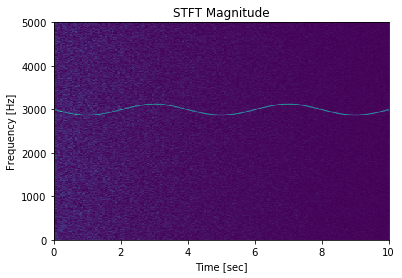

In [101]:
f, t, Zxx = stft(x, fs, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [3]:
x.shape

(100000,)

In [103]:
t, y = istft(Zxx, fs)

In [104]:
y.shape

(100000,)

In [92]:
f.shape

(501,)

In [19]:
mag = np.abs(Zxx)
phase = np.angle(Zxx)
respec = mag*np.exp(1j*phase)

In [22]:
respec.dtype

dtype('complex128')

In [23]:
t, y = istft(respec, fs, nperseg=1000)

In [24]:
y.shape

(100000,)

In [25]:
np.allclose(x, y)

True

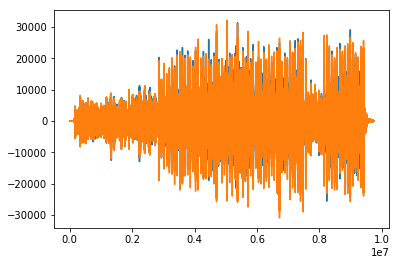

In [105]:
filename = '/home/jchu/data/DSD100/Mixtures/Dev/070 - James May - All Souls Moon/mixture.wav'
fs, data = wavfile.read(filename)
plt.plot(data[:, 0])
plt.plot(data[:, 1])
plt.show()

In [79]:
data.shape

(9748069, 2)

In [139]:
f, t, spec = stft(data[:, 0], fs=fs, nperseg=1024, noverlap=256)
#check_COLA(window='hann', nperseg=1024, noverlap=256)

In [140]:
data.shape

(9748069, 2)

In [141]:
spec.shape

(513, 12694)

In [142]:
fs

44100

In [143]:
t, y = istft(spec, fs, nfft=1024)

In [198]:
testdata = np.arange(12) + 1
length = 12
nperseg = 8
noverlap = 3
# padding both ends
n_pad_end = (nperseg/2*2 + len(testdata)) % (nperseg - noverlap)
print(n_pad_end)
print(int(nperseg/2))
testpadded = np.pad(testdata, (int(nperseg/2), int(nperseg/2+n_pad_end)), mode='constant')

0.0
4


In [199]:
testpadded

array([ 0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0,
        0,  0,  0])

In [197]:
len(testpadded)

19

In [194]:
len(testpadded) / (nperseg-noverlap)

5.333333333333333

In [150]:
nperseg = 1024
noverlap = 256
n_add_pad = (nperseg/2*2 + len(data[:, 0])) % (nperseg - noverlap)
print(n_add_pad)

101.0


In [154]:
padded = np.pad(data[:, 0], (int(nperseg/2), int(nperseg/2+n_add_pad)), mode='constant')

In [156]:
len(data[:, 0])

9748069

In [157]:
len(padded)/(nperseg - noverlap)

12694.263020833334

In [145]:
(len(data[:, 0]) - 1024) % (1024 - 256)

357

In [224]:
ch1 = data[:, 0]
check_COLA(window=hann(1024), nperseg=1024, noverlap=768)
#f, t, Zxx = stft(ch1, 44100, nperseg=1024, noverlap=256, window='hann')

False

In [211]:
ch1.shape

(9748069,)

In [18]:
# Can't reconstruct signal with the same settings used to generate the STFT -- WHY???
t, y = istft(Zxx, fs=44100, nperseg=1024, noverlap=256, window='hann')

NameError: name 'signal' is not defined

In [5]:
fs, data = wavfile.read('/home/jchu/data/DSD100/Mixtures/Dev/055 - Angels In Amplifiers - I\'m Alright/mixture.wav')
X = stft_norm((data[:, 0] + data[:, 1]/2))
xback = istft_norm(X)
wavfile.write('/home/jchu/Desktop/055-recon.wav', rate=44100, data=xback)

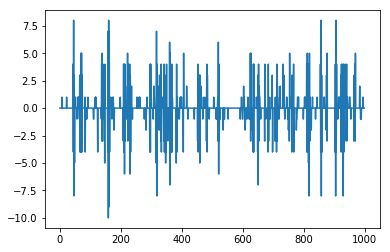

In [7]:
plt.plot(data[0:1000, 0])
plt.show()

In [73]:
maxval = np.iinfo(data.dtype).max

In [82]:
window_length = 2048
hopsize = 256
nperseg = 2048
# Front and back pad data
padded = np.pad(data[:, 0] / 2 / np.iinfo(data.dtype).max, (int(window_length), int(window_length)), mode='constant')
# Additional padding to satisfy COLA constraint
add_pad = (len(padded) - nperseg) % (nperseg - noverlap)
padded = np.pad(padded, (0, add_pad), mode='constant')
# Transform
f, t, Zxx = stft(padded, nperseg=nperseg, noverlap=(nperseg - hopsize), boundary=None)
# Get data back
t, xback = istft(Zxx, fs=fs, nperseg=nperseg, noverlap=noverlap)

In [83]:
Zxx.shape

(1025, 30948)

In [84]:
%timeit t, xback = istft(Zxx, fs=44100, nperseg=nperseg, noverlap=noverlap)

2.2 s ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
xback *= 32767

In [77]:
xback.dtype

dtype('float64')

In [36]:
len(xback)

7920384

In [37]:
len(data)

7920084

In [86]:
wavfile.write('/home/jchu/Desktop/055-recon.wav', rate=44100, data=xback)

In [26]:
mag = np.abs(Zxx)

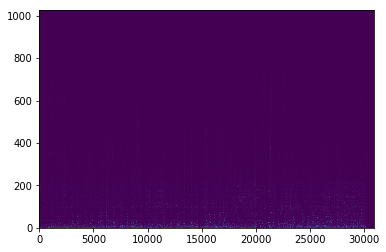

In [28]:
plt.pcolormesh(mag)
plt.show()

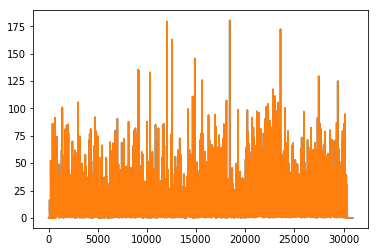

In [30]:
plt.plot(mag[500, :])
plt.show()

In [80]:
X = stft_norm((data[:, 0] + data[:, 1]) / 2)

In [40]:
X.shape

(30940, 1025)

In [66]:
%timeit xback_theirs = istft_norm(X)

2.2 s ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
xback_theirs = istft_norm(X)
wavfile.write('/home/jchu/Desktop/055-recon-2.wav', rate=44100, data=xback_theirs)

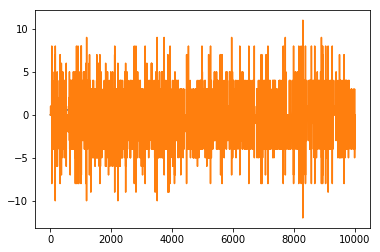

In [42]:
plt.plot(xback[0:10000])
plt.show()

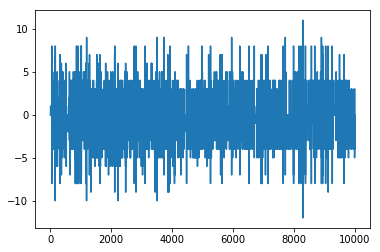

In [43]:
plt.plot(data[0:10000, 0])
plt.show()

In [45]:
data.dtype

dtype('int16')